In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os
import numpy as np
import fiona 
import json
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(1, '..')
from src.colors import *

model_path = Path('../runs_2023')

# Cross-validation

Evaluate the cross-validation performance of different YOLOv8 models.

Metrics used here are the following:

* $Precision = \frac{tp}{tp+fp}$, with IoU-threshold of 0.5
* $Recall = \frac{tp}{tp+fn}$, with IoU-threshold of 0.5
* $mAP50$ is the area under the precision-recall curve with IoU threshold of 0.5
* $mAP$ or $AP@[.5:.95]$ is the average $mAP$ for IoU from 0.5 to 0.95 with a step size of 0.05
* $IoU$ corresponds to Intersection-over-Union, the ratio between the overlap and union of two bounding boxes

All models were trained for maximum 200 epochs, with `patience=30` monitoring mAP.

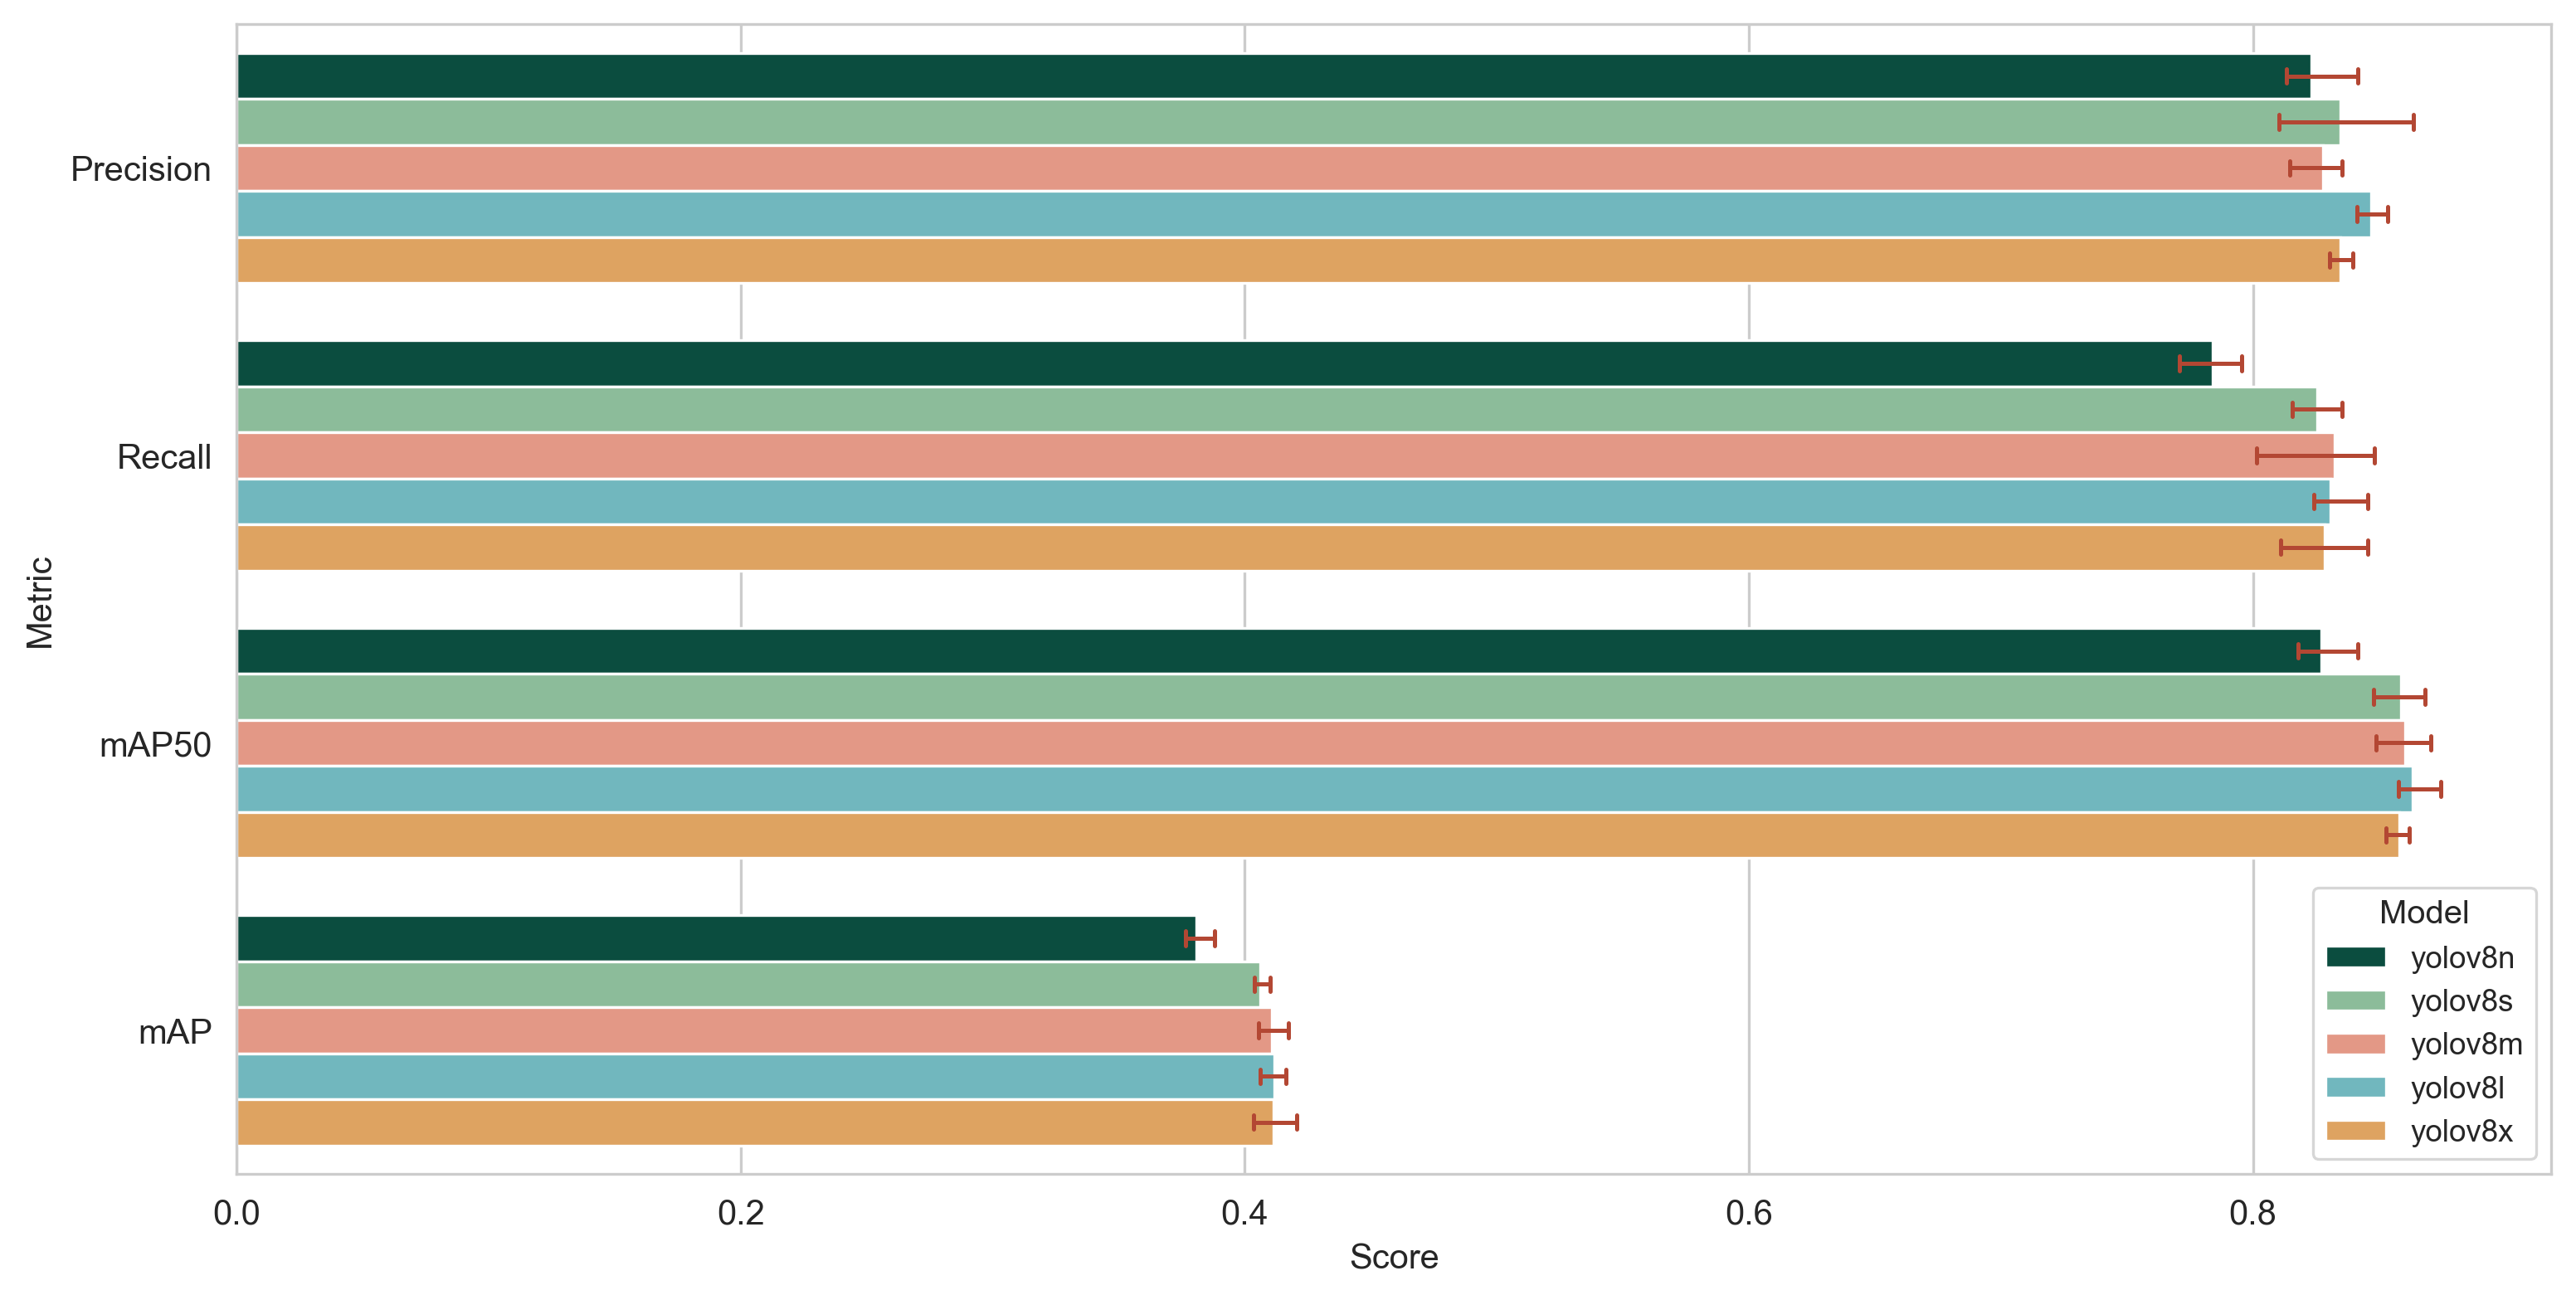

In [ ]:
#| echo: False
#| label: fig-cvres
#| fig-cap: 5-fold crossvalidation results for different model architectures.

pres = []
recs = []
mAP50s = []
mAPs = []

models = ['yolov8n_Adam', 'yolov8s_Adam', 'yolov8m_Adam',
          'yolov8l_Adam', 'yolov8x_Adam']
folds = os.listdir(model_path/models[1])

results = []
for m in models:
    for f in folds:
        res = pd.read_csv(model_path/m/f/'results.csv')
        res.rename(columns=lambda x: x.strip(), inplace=True)
        best_ix = res['metrics/mAP50-95(B)'].argmax()
        pre = np.array(res['metrics/precision(B)'])[best_ix]
        rec = np.array(res['metrics/recall(B)'])[best_ix]
        mAP50 = np.array(res['metrics/mAP50(B)'])[best_ix]
        mAP = np.array(res['metrics/mAP50-95(B)'])[best_ix]
        
        results.append([m.split('_')[0],f,pre, rec, mAP50, mAP])
resdf = pd.DataFrame(columns=['Model', 'fold', 'Precision', 'Recall', 'mAP50', 'mAP'], data=results)
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=300)
ax.set_ylim([0,1])

with sns.plotting_context('paper'):
    sns.barplot(y='variable', x='value', hue='Model', data=pd.melt(resdf, id_vars=['Model', 'fold']),
                palette=colors5, errorbar=('ci', 100), capsize=.25, errcolor='#b34733', errwidth=1.2)
    sns.move_legend(ax, 'lower right')
    plt.ylabel('Metric')
    plt.xlabel('Score')
    plt.savefig('../figures/val_results.png', bbox_inches='tight', dpi=300)
    
    plt.show()

In [ ]:
resdf.pivot_table(values=['Precision', 'Recall', 'mAP50', 'mAP'], index=['Model'], 
                  aggfunc={'Precision':[min, max, np.mean],
                           'Recall':[min, max, np.mean],
                           'mAP50':[min, max, np.mean],
                           'mAP':[min, max, np.mean]})

Precision                      Recall                         mAP  \
              max      mean      min      max      mean      min      max   
Model                                                                       
yolov8l   0.85450  0.846998  0.83973  0.84975  0.830720  0.82398  0.41694   
yolov8m   0.83592  0.827938  0.81134  0.84939  0.832380  0.80153  0.41739   
yolov8n   0.84688  0.823160  0.81273  0.79587  0.783928  0.76895  0.38816   
yolov8s   0.86363  0.834556  0.80835  0.83639  0.825554  0.81469  0.41098   
yolov8x   0.84028  0.834728  0.83019  0.84891  0.828462  0.80858  0.42065   

                              mAP50                     
             mean      min      max      mean      min  
Model                                                   
yolov8l  0.411712  0.40505  0.87459  0.863334  0.85743  
yolov8m  0.410742  0.40496  0.87071  0.860378  0.84545  
yolov8n  0.380828  0.37637  0.84323  0.827192  0.81776  
yolov8s  0.406258  0.40374  0.86933  0.858632  0.84776  
yolov8x  0.411532  0.40231  0.86203  0.858136  0.85131

## Visual comparisation of results

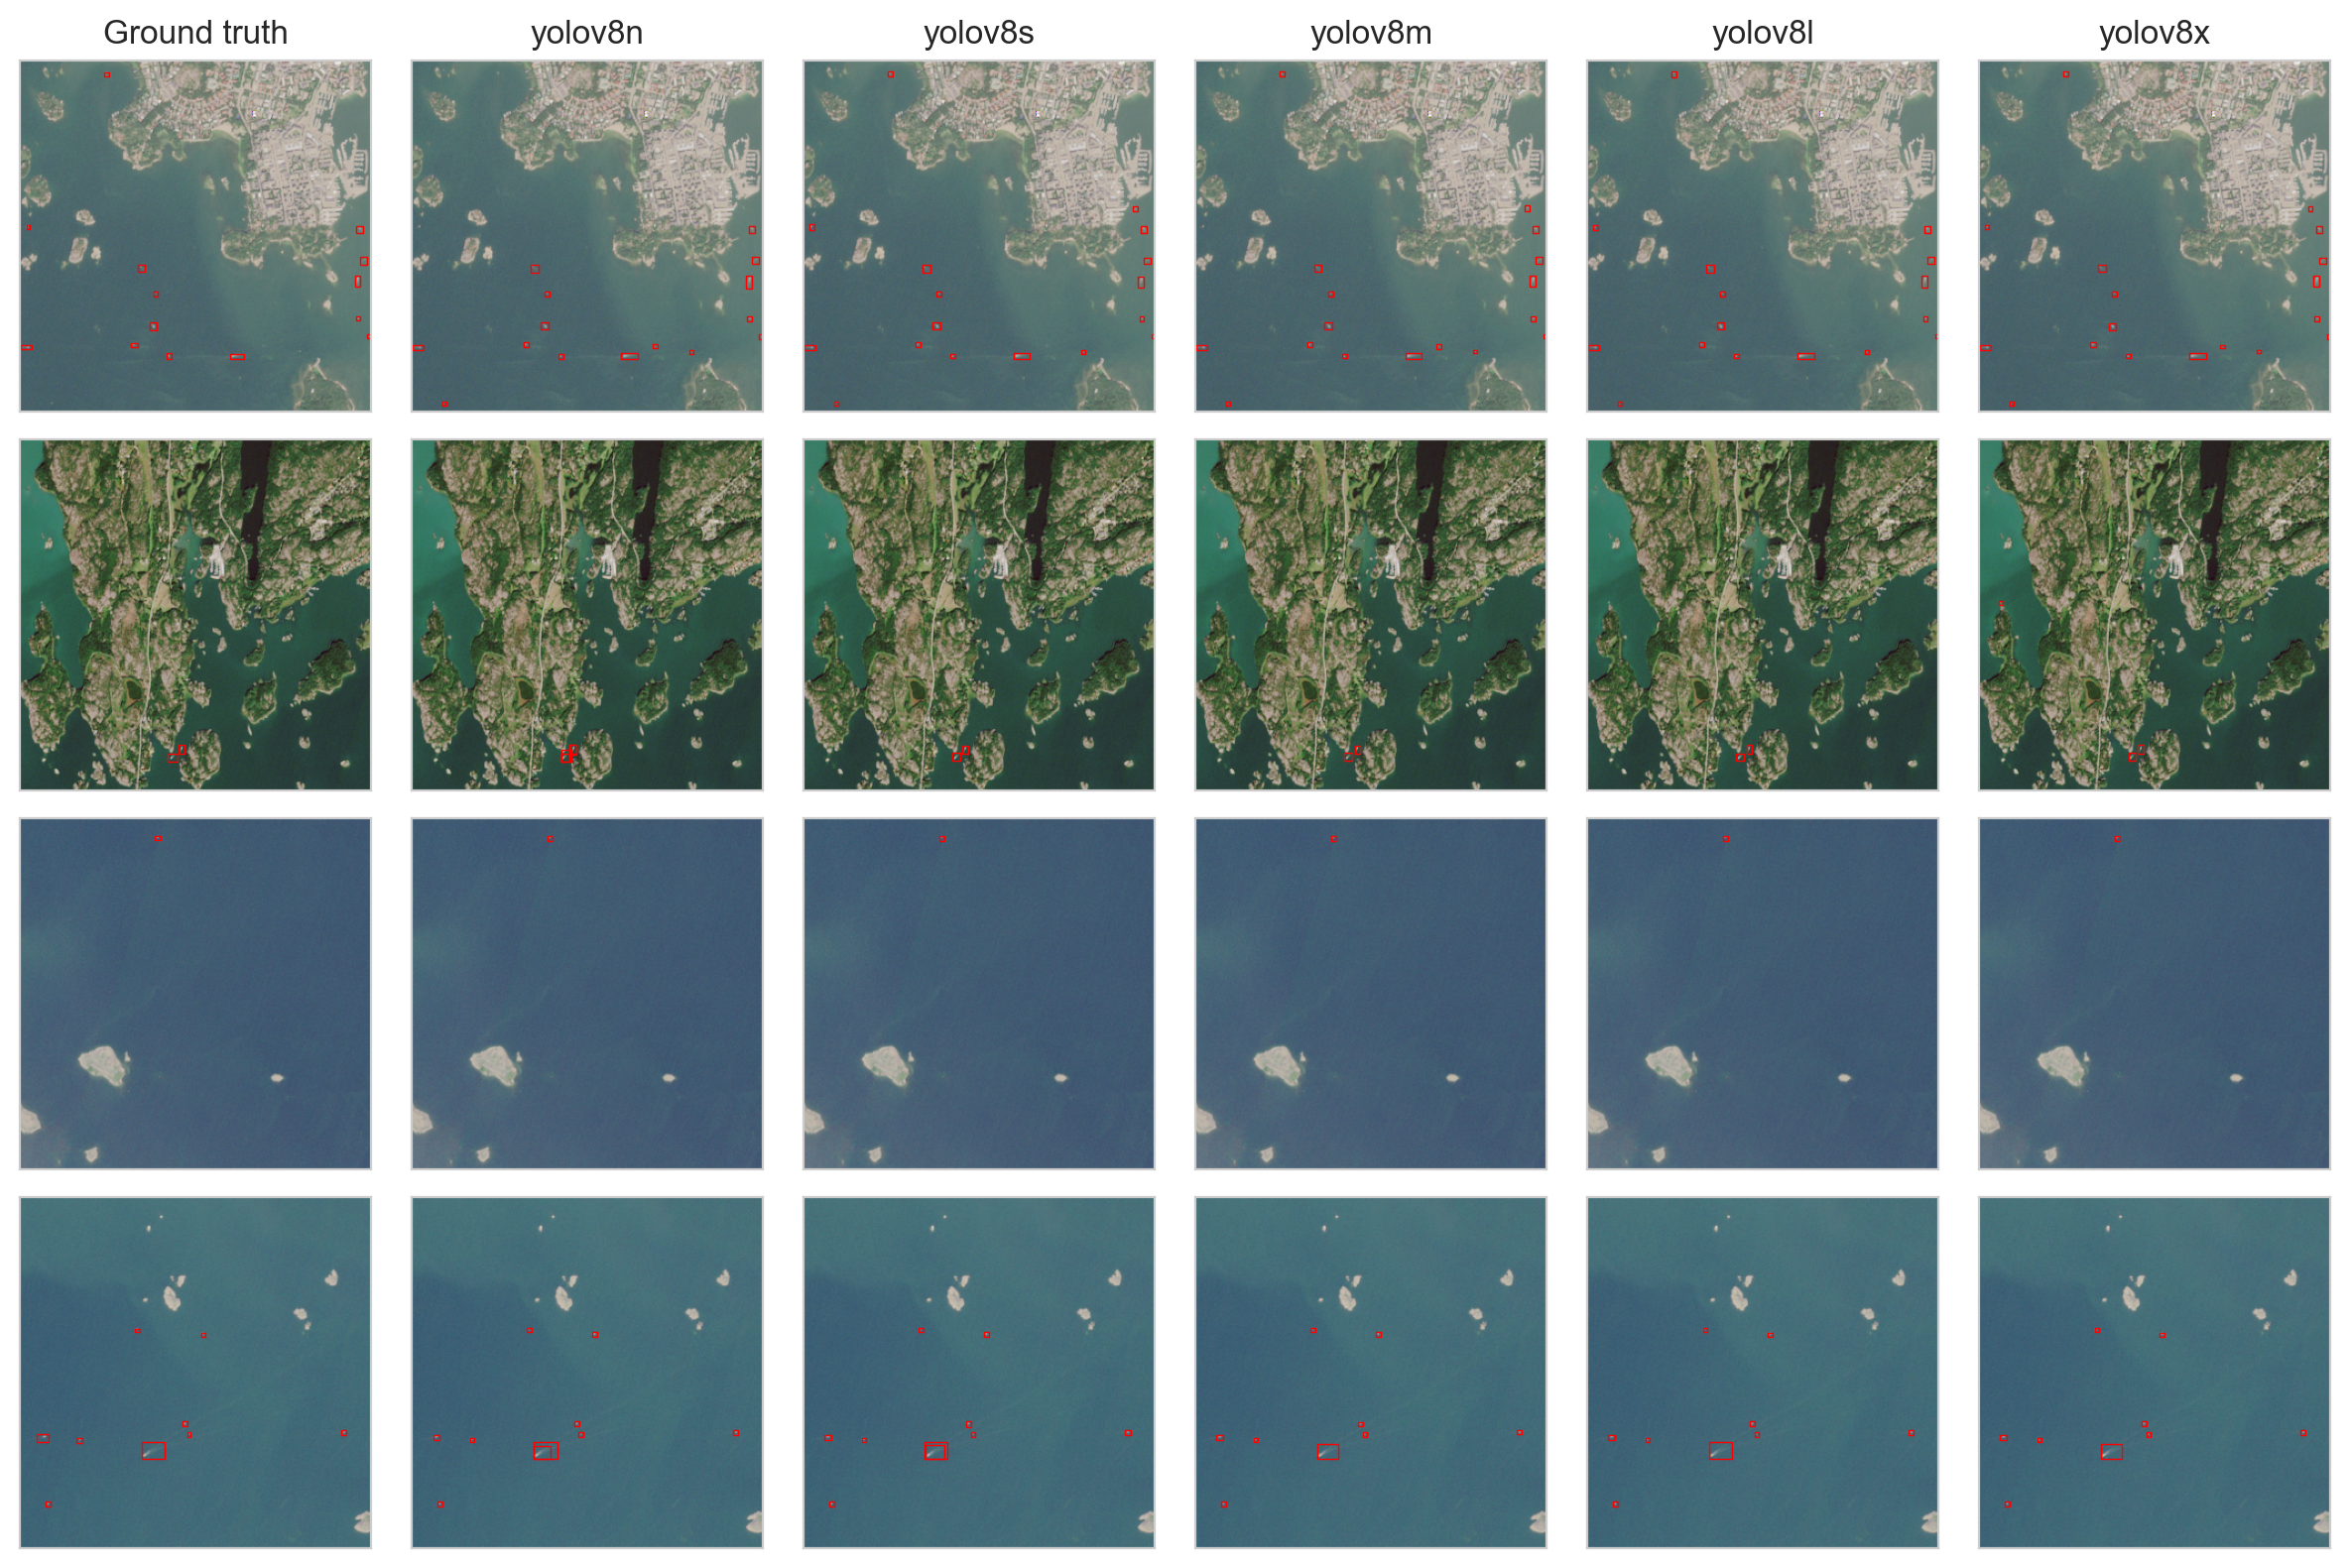

In [ ]:
#| echo: false
#| label: fig-exres
#| fig-cap: Example result comparison for different models

import random
from PIL import Image
from matplotlib.patches import Rectangle
from ultralytics import YOLO
import cv2


#with open('../data/processed/fold_3.txt') as src:
#    images = [i.replace('/scratch/project_2007454/ship_detection', '..') for i in src.read().split('\n')]
    
#testims = random.sample(images, 4)

testims = ['../data/processed/35VLG/20220721/images/R9C25.tif',
           '../data/processed/34VEM/20220813/images/R14C25.tif',
           '../data/processed/34VEM/20220721/images/R20C12.tif',
           '../data/processed/34VEM/20220721/images/R12C12.tif']

fig, axs = plt.subplots(4,6, dpi=200, figsize=(12,8))
for a in axs.flatten(): 
    a.set_xticks([])
    a.set_yticks([])

axs[0,0].set_title('Ground truth')
    
for i, t in enumerate(testims):
    im = Image.open(t)
    axs[i,0].imshow(im)
    with open(t.replace('images', 'labels').replace('tif', 'txt')) as src:
        anns = src.read().split('\n')[:-1]
    for ann in anns:
        xc, yc, w, h = [float(a)*320 for a in ann.split(' ')[1:]]
        axs[i,0].add_patch(Rectangle((xc-w/2, yc-h/2), w, h, edgecolor='red', facecolor='none', linewidth=.5))

for j, m in enumerate(models):
    axs[0,j+1].set_title(m.split('_')[0])
    model = YOLO(model_path/m/'fold_3/weights/best.pt')
    model.to('cuda')
    for i, t in enumerate(testims):
        im = Image.open(t)
        axs[i,j+1].imshow(im)
        preds = model(im, verbose=False)
        for xc, yc, w, h in preds[0].boxes.xywh.cpu():
            axs[i,j+1].add_patch(Rectangle((xc-w/2, yc-h/2), w, h, edgecolor='red', facecolor='none', linewidth=.5))
plt.tight_layout()
#plt.savefig('../draft/fig-visual-res.png', dpi=200, bbox_inches='tight')

# Test set results

The predictions for the test set are cleaned using the following steps:

1. All prediction whose centroid points are not located on water are discarded. The water mask used contains layers `jarvi` (Lakes), `meri` (Sea) and `virtavesialue` (Rivers as polygon geometry) from the Topographic database by the National Land Survey of Finland. Unfortunately this also discards all points not within the Finnish borders. (The National Land Survey of Finland Topographic Database 04/2023, license CC 4.0 BY)
2. All predictions whose centroid points are located on water rock areas are discarded. The mask is the layer `vesikivikko` (Water rock areas) from the Topographic database.
3. All predictions that contain an above water rock within the bounding box are discarded. The mask contains classes `38511`, `38512`, `38513` from the layer `vesikivi` in the Topographical database.
4. All predictions that contain a lighthouse or a sector light within the bounding box are discarded. Lighthouses and sector lights come from Finnish Transport Infrastructure Agency, `ty_njr` class ids are 1, 2, 3, 4, 5, 8. (Finnish Transport Agency / Open API, license CC 4.0 BY)
5. All predictions that are wind turbines, found in Topographic database layer `tuulivoimalat`
6. TODO Filter aquaculture and net pens as soon as suitable layer for them is found
7. All predictions that are obviously too large are discarded. The prediction is defined to be "too large" if either of its edges is longer than 750 meters.

Topographic database can be acquired [here](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data/expert-users/product-descriptions/topographic-database), and the data from Finnish Transport Infrastructure Agency is available [here](https://paikkatieto.vaylapilvi.fi/suomen-vaylat/?lang=en) (Maritime transport, Aids to navigation).

Evaluate the results with COCO metrics. True positives are defined based on IoU of predicted polygons using `shapely`.

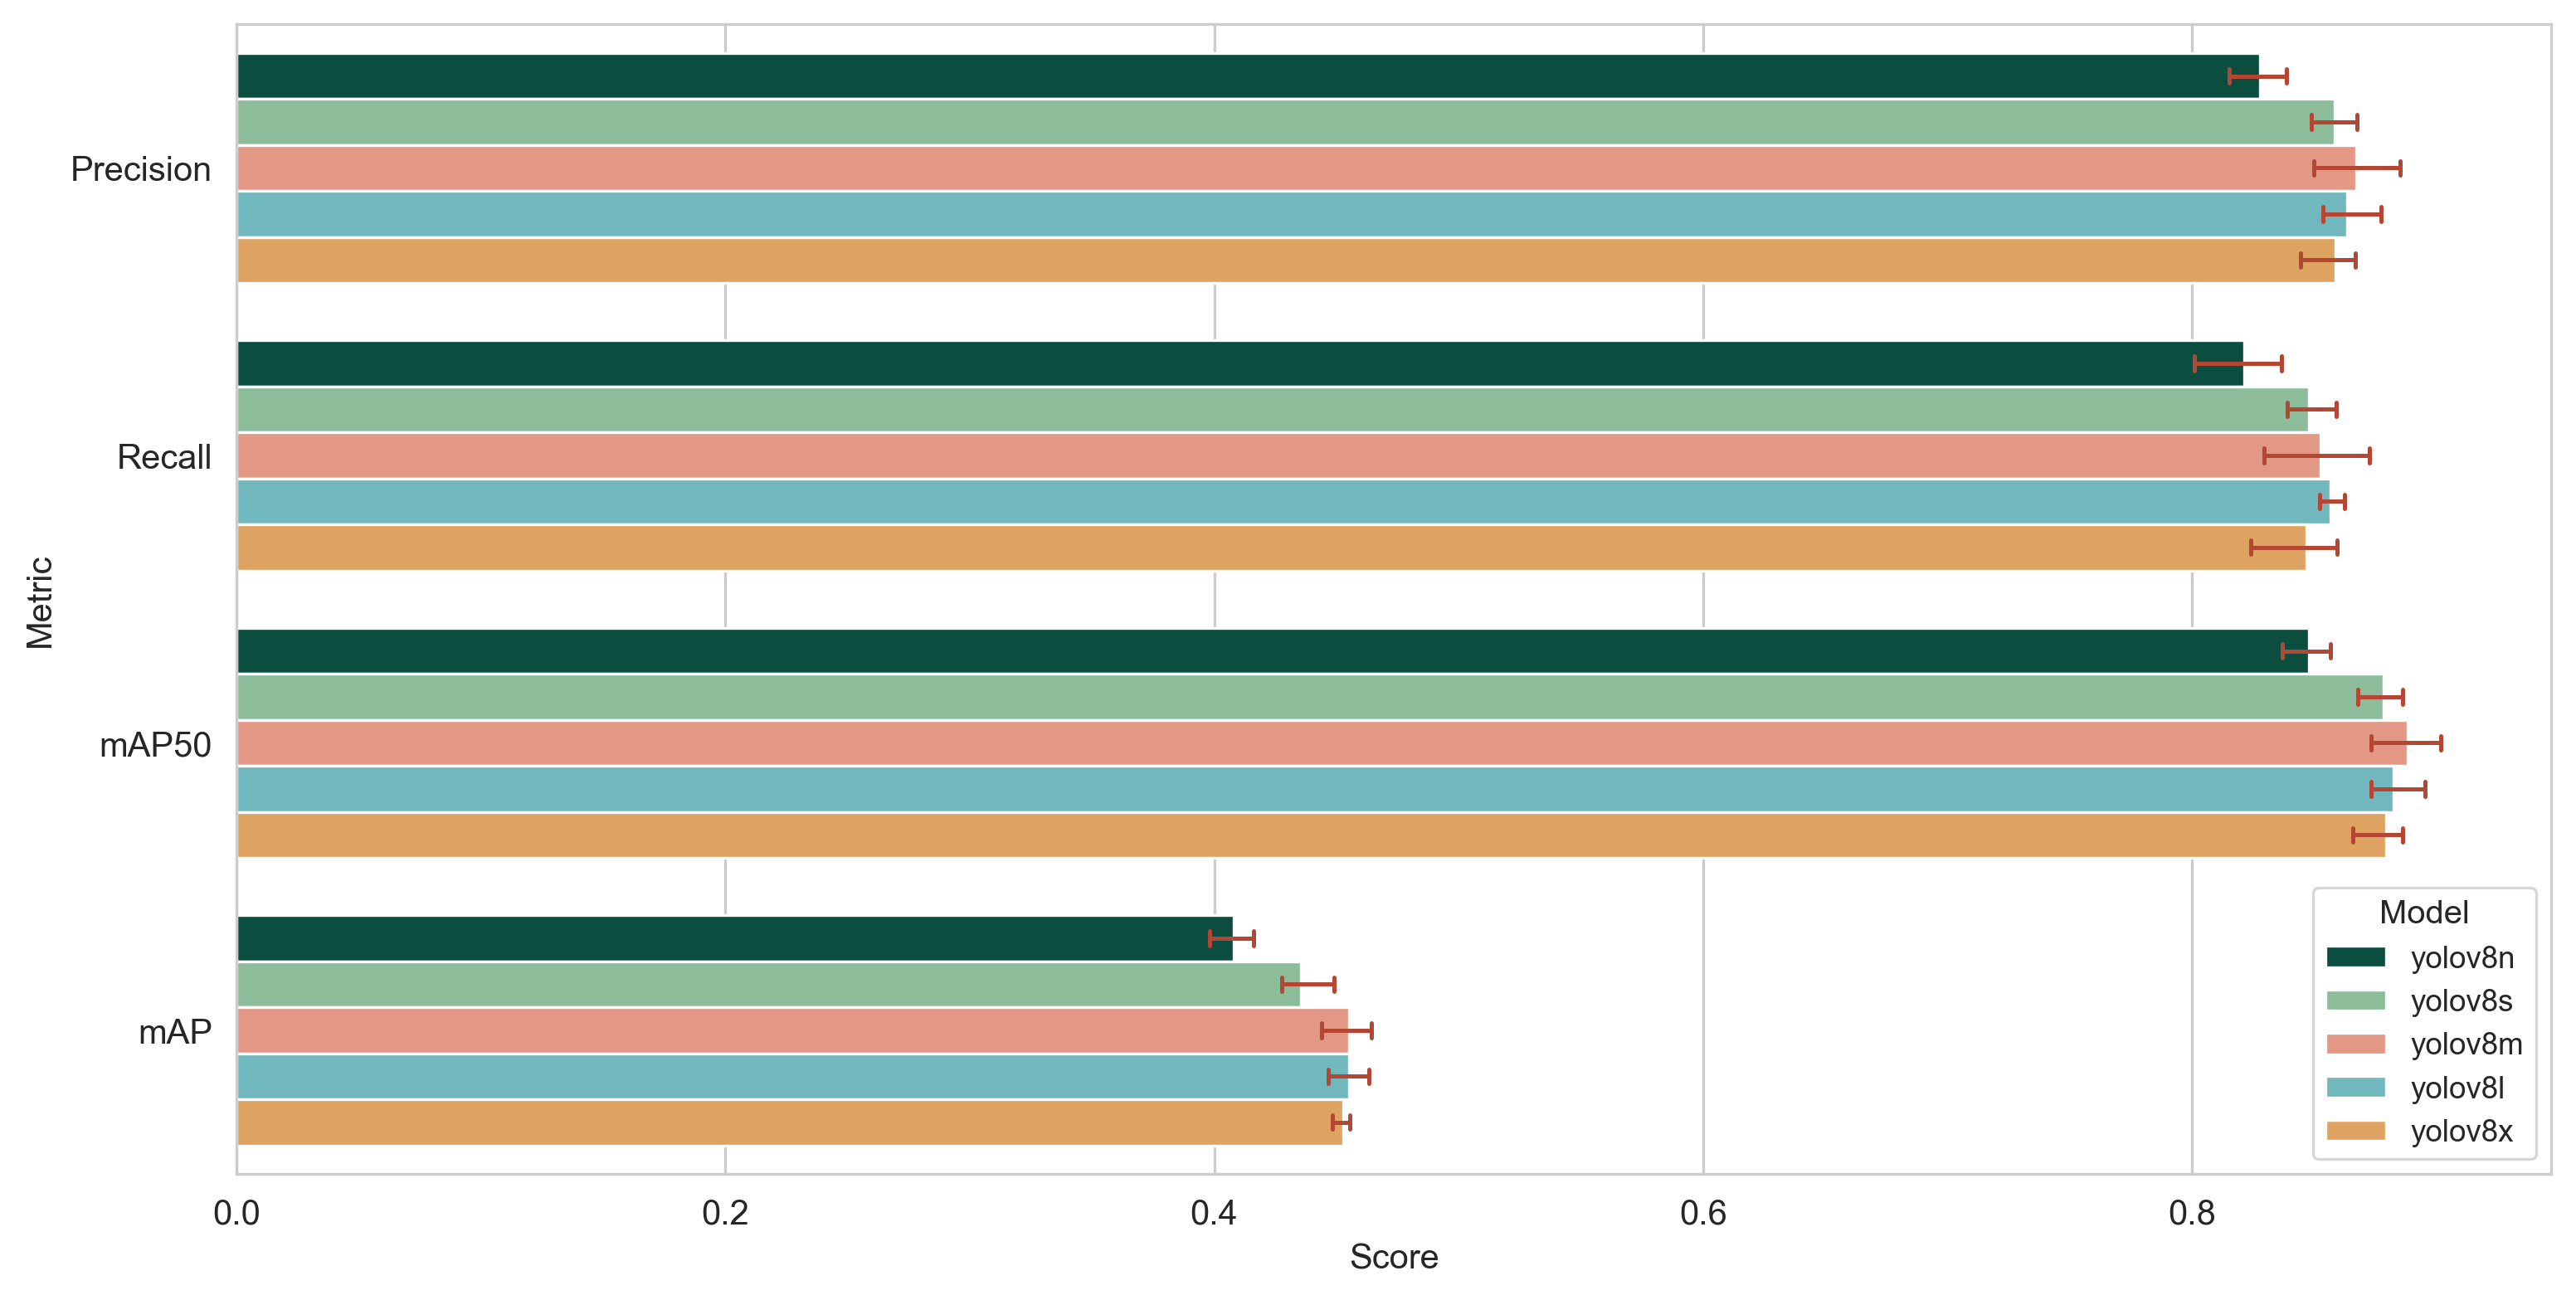

In [ ]:
#| echo: False
#| label: fig-testres
#| fig-cap: Test set results by model architecture.

pres = []
recs = []
mAP50s = []
mAPs = []

models = ['yolov8n_Adam', 'yolov8s_Adam', 'yolov8m_Adam',
          'yolov8l_Adam', 'yolov8x_Adam']
folds = os.listdir(model_path/models[1])

results = []
for m in models:
    for f in folds:
        with open(model_path/m/f/'evalresults.json','r') as f:
            res = json.load(f)
        pre = res['precision']
        rec = res['recall']
        mAP50 = res['mAP50']
        mAP = res['mAP50-95']
        
        results.append([m.split('_')[0],f,pre, rec, mAP50, mAP])
resdf = pd.DataFrame(columns=['Model', 'fold', 'Precision', 'Recall', 'mAP50', 'mAP'], data=results)
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=300)
ax.set_ylim([0,1])

with sns.plotting_context('paper'):
    sns.barplot(y='variable', x='value', hue='Model', data=pd.melt(resdf, id_vars=['Model', 'fold']),
                palette=colors5, errorbar=('ci', 100), capsize=.25, errcolor='#b34733', errwidth=1.2)
    sns.move_legend(ax, 'lower right')
    plt.ylabel('Metric')
    plt.xlabel('Score')
    plt.savefig('../figures/test_results.png', bbox_inches='tight', dpi=300)
    
    plt.show()

In [ ]:
resdf.pivot_table(values=['Precision', 'Recall', 'mAP50', 'mAP'], index=['Model'], 
                  aggfunc={'Precision':[min, max, np.mean],
                           'Recall':[min, max, np.mean],
                           'mAP50':[min, max, np.mean],
                           'mAP':[min, max, np.mean]})

Precision                        Recall                           mAP  \
              max      mean       min       max      mean       min       max   
Model                                                                           
yolov8l  0.877358  0.863431  0.853155  0.863636  0.856511  0.851966  0.463503   
yolov8m  0.888228  0.867010  0.846107  0.875307  0.852703  0.824939  0.464857   
yolov8n  0.840748  0.827731  0.815111  0.838452  0.821499  0.800983  0.417369   
yolov8s  0.869427  0.858166  0.848823  0.860565  0.847666  0.838452  0.448884   
yolov8x  0.867101  0.858786  0.841434  0.859951  0.846929  0.817568  0.455922   

                                mAP50                      
             mean       min       max      mean       min  
Model                                                      
yolov8l  0.455233  0.446569  0.896509  0.882343  0.873198  
yolov8m  0.455235  0.443199  0.903983  0.888179  0.871075  
yolov8n  0.407895  0.398058  0.856725  0.847745  0.836608  
yolov8s  0.435405  0.427492  0.886253  0.878227  0.867800  
yolov8x  0.452866  0.446565  0.886113  0.879400  0.865797

Best performing model for each architecture is available on [https://huggingface.co/mayrajeo/marine-vessel-detection](https://huggingface.co/mayrajeo/marine-vessel-detection).

In [ ]:
resdf

,Model,fold,Precision,Recall,mAP50,mAP
0,yolov8n,<_io.TextIOWrapper name='../runs_2023/yolov8n_...,0.835373,0.838452,0.856328,0.410469
1,yolov8n,<_io.TextIOWrapper name='../runs_2023/yolov8n_...,0.820560,0.828624,0.837642,0.398058
2,yolov8n,<_io.TextIOWrapper name='../runs_2023/yolov8n_...,0.815111,0.815111,0.836608,0.403318
3,yolov8n,<_io.TextIOWrapper name='../runs_2023/yolov8n_...,0.840748,0.800983,0.856725,0.410264
4,yolov8n,<_io.TextIOWrapper name='../runs_2023/yolov8n_...,0.826864,0.824324,0.851424,0.417369
5,yolov8s,<_io.TextIOWrapper name='../runs_2023/yolov8s_...,0.855296,0.853194,0.881689,0.434618
6,yolov8s,<_io.TextIOWrapper name='../runs_2023/yolov8s_...,0.869427,0.838452,0.886253,0.448884
7,yolov8s,<_io.TextIOWrapper name='../runs_2023/yolov8s_...,0.858302,0.844595,0.877176,0.437534
8,yolov8s,<_io.TextIOWrapper name='../runs_2023/yolov8s_...,0.858982,0.860565,0.878220,0.428499
9,yolov8s,<_io.TextIOWrapper name='../runs_2023/yolov8s_...,0.848823,0.841523,0.867800,0.427492
